In [208]:
import numpy as np
import pandas as pd
from numpy import *
from scipy.integrate import odeint
from matplotlib.pyplot import *
import matplotlib.pyplot as pl
from scipy.integrate import odeint
from scipy.optimize import least_squares
from scipy import optimize
from datetime import date, timedelta
import random
import math


In [209]:
Psi = pd.read_csv('dados/Psi.csv')

Dados= pd.read_csv ('dados/Dados_novos_BAHIA.csv')
vacinados_dados = Dados['Vacinados'].fillna(0)
mortos_dados = Dados['Mortos']
datas = Dados["datetime"]

In [210]:
npd = len(Psi)

Nfo = 8
Psi = Psi.values
Psif = [[0]]*npd

for k in range(1, npd):
    if (k-Nfo) < 0 :
        Psif[k] = 1/k*sum(Psi[0:k])
    else:
        Psif[k] = 1/Nfo*sum(Psi[k-Nfo:k])

Psif.pop(0)


[0]

In [211]:
vacinados_dados_aux = np.copy(vacinados_dados)
for i in range(1,len(vacinados_dados_aux)):
    diff = vacinados_dados_aux[i] - vacinados_dados_aux[i-1]
    if diff < 0:
        vacinados_dados_aux[i-1] = vacinados_dados_aux[i]

novos_vacinados = np.diff(vacinados_dados_aux)
novos_vacinados = novos_vacinados.tolist()
novos_vacinados.insert(0, 0 )
len(novos_vacinados)

334

In [212]:

# ts0 = np.arange(len(np.cumsum(novos_vacinados)))
# a = np.polyfit(ts0,np.cumsum(novos_vacinados),50)
# tau=np.poly1d(a)

In [213]:
def SIR(y,t, args):
    k = 1/4
    gamma_a = 1/3.5
    gamma_s = 1/4
    gamma_h = 0.18
    gamma_u = 0.13342706158133355
    mi_u = 0.4
    qsi = 0.53
    h = 0.06
    h_v = 0
    mi_h = 0.15
    ome_h = 0.14
    ome_u = 0.29
    delta = 0.31
    p = 0.2
    
    beta0, beta1, beta2,beta3, t1, t2,t3 = args

    if t<t1:
        beta=beta0    
    elif (t>=t1):
        beta=beta1
    elif (t>=t2):
        beta=beta2
    elif t>=t3:
        beta=beta3

    # beta_v = beta*0.5
    beta_v = beta/2
    
    delta_av = 0.31
    delta_sv = 0.31
    phi_e = 0.8
    k_v=1/3
    p_v = 0.1
    gamma_av = 1/3.5
    gamma_sv = 1/4
    gamma_vu=0.26
    qsi_v = 0.99
    eps=0.5
    mi_vh=0.03
    mi_vu=0.25
    gamma_vh=0.08

    tau = novos_vacinados[int(t)]

    N=14873064#############
    #N=1#########
    psi= 0.5#Psif[int(t)]
    S=y[0]
    E=y[1]
    V=y[2]
    Sv=y[3]
    Ev=y[4]
    Ia=y[5]
    Is=y[6]
    Iav=y[7]
    Isv=y[8]
    H=y[9]
    Hv=y[10]
    U=y[11]
    Uv=y[12]
    R=y[13]
    Rv=y[14]
    D=y[15]
    Nw=y[16]
    NwV=y[17]

    dSdt = (-(1-psi)*beta*S*(Is+delta*Ia+delta_av*Iav+delta_sv*Isv)) - tau/N
    dEdt = ((1-psi)*beta*S*(Is+delta*Ia+delta_av*Iav+delta_sv*Isv)) - k*E
    dVdt = tau/N - phi_e*V - ((1-psi)*beta*V*(Is+delta*Ia+delta_av*Iav+delta_sv*Isv))
    dSvdt =  phi_e*(1-eps)*V - ((1-psi)*beta_v*Sv*(Is+delta*Ia+delta_av*Iav+delta_sv*Isv)) #- phi_e*eps*Sv
    dEvdt = ((1-psi)*beta_v*Sv*(Is+delta*Ia+delta_av*Iav+delta_sv*Isv)) - k_v*Ev
    dIadt = (1-p)*k*E - gamma_a*Ia
    dIsdt = p*k*E - gamma_s*Is
    dIavdt = (1-p_v)*k_v*Ev - gamma_av*Iav
    dIsvdt = p_v*k_v*Ev - gamma_sv*Isv   
    dHdt = h*qsi*gamma_s*Is + (1-mi_u+ome_u*mi_u)*gamma_u*U - gamma_h*H   
    dHvdt = h_v*qsi_v*gamma_sv*Isv + (1-mi_vu+ome_u*mi_vu)*gamma_vu*Uv - gamma_vh*Hv    
    dUdt = h*(1-qsi)*gamma_s*Is + ome_h*gamma_h*H - gamma_u*U
    dUvdt = h_v*(1-qsi_v)*gamma_sv*Isv + ome_h*gamma_vh*Hv - gamma_u*Uv
    dRdt = gamma_a*Ia + (1-h)*gamma_s*Is + (1-mi_h)*(1-ome_h)*gamma_h*H
    dRvdt = gamma_av*Iav + (1-h_v)*gamma_sv*Isv + (1-mi_vh)*(1-ome_h)*(gamma_vh*Hv) + phi_e*eps*V
    dDdt = (1-ome_h)*(mi_h*gamma_h*H +mi_vh*gamma_vh*Hv) + (1-ome_u)*(mi_u*gamma_u*U+mi_vu*gamma_vu*Uv)
    dNwdt = p*k*E + p_v*k_v*Ev
    dNwVdt = tau/N
        
    return [dSdt, dEdt, dVdt, dSvdt, dEvdt, dIadt, dIsdt, dIavdt, dIsvdt, dHdt, dHvdt, dUdt, dUvdt, dRdt, 
            dRvdt, dDdt, dNwdt, dNwVdt]


In [214]:
def lq_SIR(pars, data, ts0, q0):

    beta0, beta1, beta2,beta3, t1, t2, t3 = pars
    #parameters
    parode = beta0, beta1, beta2,beta3, t1, t2,t3
    #calls integrator

    qs = odeint(SIR, q0, ts0, args=(parode,),mxstep=1000000)
    mortos = np.diff(qs[:,-3]*14930634)
    #define the standardized residuals
    errMortos = (mortos - data) / np.sqrt(mortos+1)

    return np.r_[errMortos]

In [215]:
def Best_Fit(data,n_tries, ts0, q0):

    # #DEEFINE THE INTERVALS OF PARS[0, 2.],[0, 2.], [0, 5.], [0, 5.],[0, 5.],[0, 80], [80, 170], [170, 240], [240, 400]
    intervals = np.array([[0, 5.],[0, 5.], [0, 5.], [0, 5.], [0, 160], [160, 260], [260, 300]])

    #NUMBER OF FITS
    #best error starts at inft 
    best_err = np.inf
    #aj the number of best fists 
    aj = 0
    for i in range(n_tries):
        if i%5 == 0:
            print(i)
            
        #create a set of parameters in the interval
        par0 = np.random.rand(len(intervals))
        par0 = intervals[:,0] + par0 * (intervals[:,1] - intervals[:,0])
        try:
            res = least_squares(lambda pars: lq_SIR(pars,data, ts0, q0), par0, bounds=(intervals[:,0], \
                                                intervals[:,1]))

            ier = res.status
            #if converges
            if ier >= 1 and ier <= 4:
                if res.cost < best_err:
                    #best_err = erro
                    best_err = res.cost
                    #best_pop = parametro
                    best_pop = res.x
                    #+1 best fit
                    aj = aj +1
                    print('achou',aj)
        except Exception as exp:
            print(exp)
            pass
                #in does not converge, do nothing

    return best_pop

In [216]:
N=14873064

#initial conditions
q0 = [
    0.8002151436282163 ,
    0.0023662791892471815,
    0,
    0,
    0,
    0.0015491725384642486,
    0.0004385474858925033,
    0,
    0,
    3.0058880370174367e-05,
    0.0,
    2.5542546092586197e-05,
    0.0,
    0.15650499264821266,
    0,
    9159/N,
    0.03581418879497971,
    0
]

#Run the minimizer
n_tries=100  #Quanto maior mais certeza do resultado. Colocar em 100 para roda com mais certeza (Ou até maiws se for necessário)
ts0 = np.arange(len(novos_vacinados))
# best_pop=Best_Fit(np.diff(mortos_dados), n_tries, ts0, q0)

# beta0, beta1, beta2, beta3, t1, t2, t3 = best_pop

#Create an x axixis for plotting the function.
#parameters
# parode = [beta0, beta1, beta2, beta3, t1, t2, t3]

parode = [  1.90221545,   3.76585085,   2.14629225,   3.27760444,
       126.48480189, 172.97799643, 288.57269974]
# calls integrator

qs = odeint(SIR,q0, ts0,args=(parode,),mxstep=1000000)

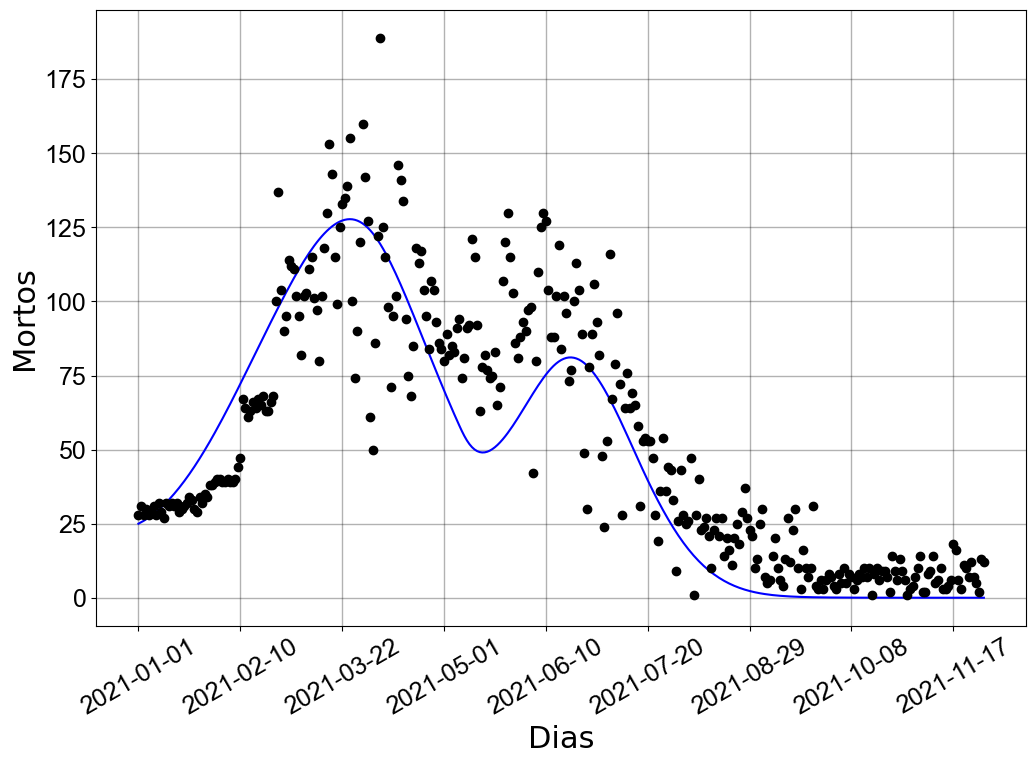

In [218]:

#Save Fig
#fig.savefig(r"Fits\\"+s+file+".png",bbox_inches='tight')

qi = qs[:,-3] #mortes acumulados

#Plotting
#Create the figure and the graph.
fig, ax = pl.subplots(figsize=(12,8))

#Create a grid for visualization.
ax.grid(which='major', axis='both', color='black',linewidth=1.,alpha=0.3)
#Plot the points(Scatters). s=size, zorder= priority->(puttin g the points in at the front of everything).
datas = datas[:len(np.diff(mortos_dados))]
ax.scatter(datas[:len(np.diff(mortos_dados))], np.diff(mortos_dados),color='black',zorder=3,label='Reported data')
axvline(0.021, 0, 19, ls=':')

#Plot the fitted function as a line.
ax.plot(datas, np.diff(N*qi),color='blue',label='Fitted function')
ax.autoscale()

#Set the labels
ax.set_ylabel('Mortos',fontsize=22)
ax.set_xlabel('Dias', fontsize=22)
#Set the title
#The size of the numbers on the axixis
ax.tick_params(labelsize=18)

#Limiting the ammount of dates on the X axixs
ax.xaxis.set_major_locator(pl.MaxNLocator(10))
#Rotating the dates for better visualization
pl.setp(ax.get_xticklabels(), rotation=30)


#Setting the font of the numbers on the axixis as ARIAL 
for tick in ax.get_xticklabels():
    tick.set_fontname("Arial")
for tick in ax.get_yticklabels():
    tick.set_fontname("Arial")  

#Show Graph       
pl.show()


In [ ]:
best_pop    

array([  1.90221545,   3.76585085,   2.14629225,   3.27760444,
       126.48480189, 172.97799643, 288.57269974])

NameError: name 'dates' is not defined

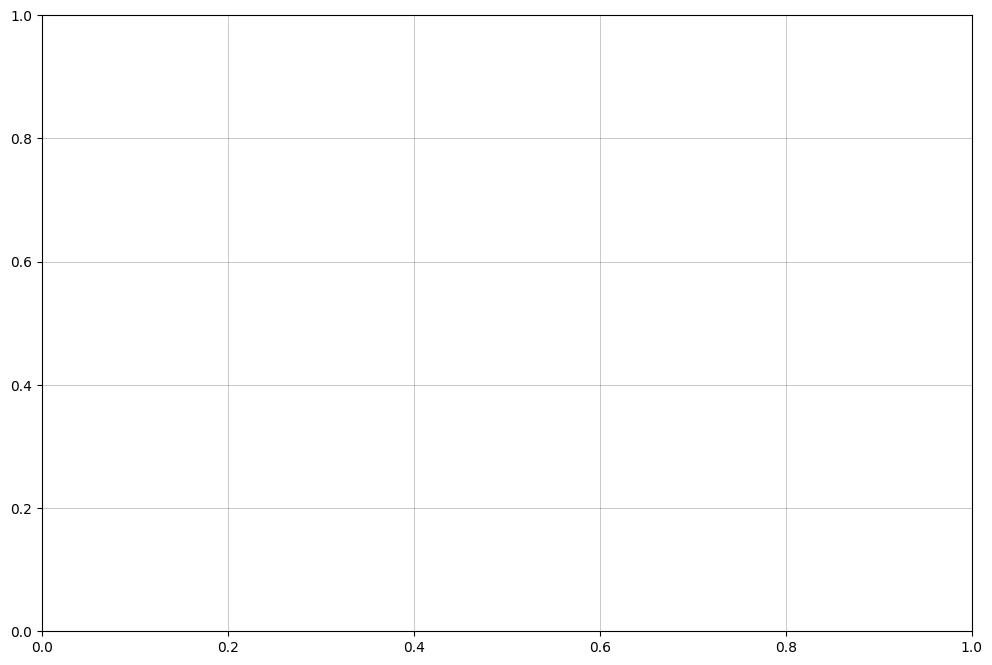

In [ ]:

#Save Fig
#fig.savefig(r"Fits\\"+s+file+".png",bbox_inches='tight')

qi = qs[:,-1] #Casos acumulados

#Plotting
#Create the figure and the graph.
fig, ax = pl.subplots(figsize=(12,8))

#Create a grid for visualization.
ax.grid(which='major', axis='both', color='black',linewidth=.5,alpha=0.3)
#Plot the points(Scatters). s=size, zorder= priority->(puttin g the points in at the front of everything).
ax.scatter(dates[:len(vacinados_dados)], (vacinados_dados),color='black',zorder=3,label='Reported data')

#Plot the fitted function as a line.
ax.autoscale()

#Set the labels
ax.set_ylabel('Número de pessoas vacinadas',fontsize=22)
ax.set_xlabel('Dias', fontsize=22)

#Set the title
#The size of the numbers on the axixis
ax.tick_params(labelsize=18)

#Limiting the ammount of dates on the X axixs
ax.xaxis.set_major_locator(pl.MaxNLocator(10))
#Rotating the dates for better visualization
pl.setp(ax.get_xticklabels(), rotation=30)


#Setting the font of the numbers on the axixis as ARIAL 
for tick in ax.get_xticklabels():
    tick.set_fontname("Arial")
for tick in ax.get_yticklabels():
    tick.set_fontname("Arial")  

#Show Graph       
pl.show()
